# Transfer Learning to detect warblers in the Mt Kenya National Park
We will use data collected from the Mt Kenya National Part to build a detector for the Brown Woodland Warbler, Cinnamon Bracken Warbler and Mountain Yellow Warbler. These are very common in the MKNP. Have a look at some pictures:
* [Brown Woodland Warbler](https://ebird.org/species/brwwar1)
* [Cinnamon Bracken Warbler](https://ebird.org/species/cibwar1)
* [Mountain Yellow Warbler](https://ebird.org/species/moywar1)

## Audio
We will listen to some audio an plot spectrograms.

In [1]:
import os
import json
import random
import librosa

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import bvc_helper_funcs as bhf

import IPython.display as ipd
import ipywidgets as widgets

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, auc, RocCurveDisplay

2025-02-23 22:18:58.828868: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-23 22:18:58.853370: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-23 22:18:58.853404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-23 22:18:58.854019: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 22:18:58.857901: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-23 22:18:58.858227: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# annotation file 
with open('../annotations/single_species_filenames.json', 'r') as fp:
    single_species_filenames = json.load(fp)

In [3]:
audio_dir = '../audio'

In [4]:
sp_select = widgets.Dropdown(
    options=['Brown Woodland Warbler', 'Cinnamon Bracken Warbler', 'Mountain Yellow Warbler'],
    value='Brown Woodland Warbler',
    description='Species:',
    disabled=False,
)

In [5]:
display(sp_select)

Dropdown(description='Species:', options=('Brown Woodland Warbler', 'Cinnamon Bracken Warbler', 'Mountain Yell…

In [6]:
# Select species files 
# starts with 'D' selects DeKUWC
# starts with 'M' selects MKNP

# files per species
for sp in sp_select.options:
    sp_files = [k for k,v in single_species_filenames.items() if v == sp and k.startswith('M')]

    print(sp, len(sp_files))


sp_files = [k for k,v in single_species_filenames.items() if v == sp_select.value and k.startswith('M')]
sp_file = random.choice(sp_files)

Brown Woodland Warbler 224
Cinnamon Bracken Warbler 14
Mountain Yellow Warbler 14


In [7]:
ipd.Audio(os.path.join('../audio/', sp_file))

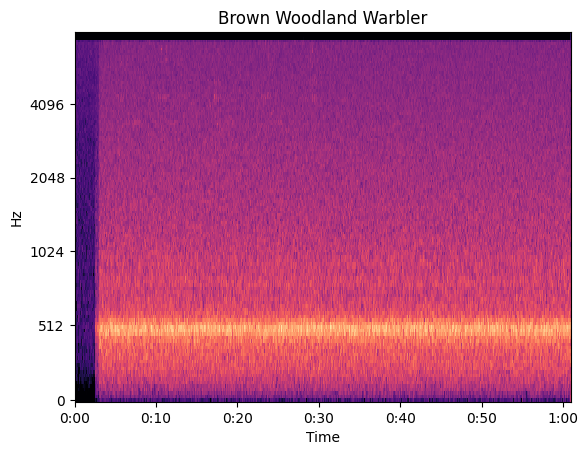

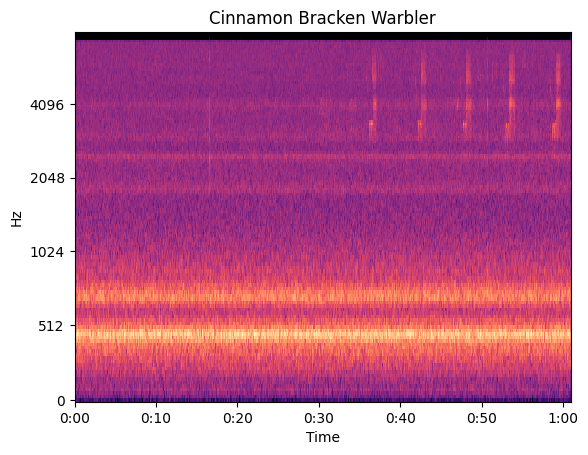

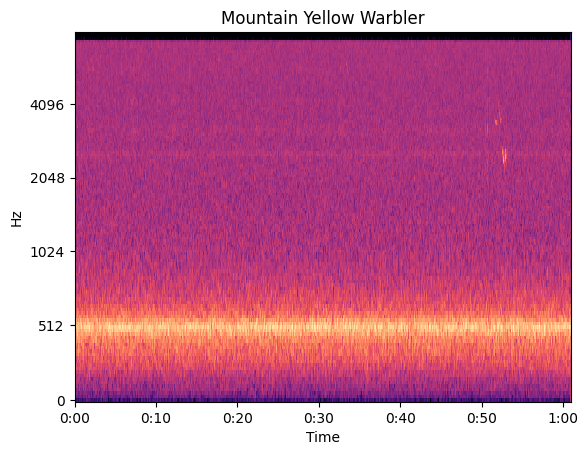

In [8]:
# plot a spectrogram per species
window_ms = 40


for sp in sp_select.options:
    sp_files = [k for k,v in single_species_filenames.items() if v == sp and k.startswith('M')]

    sp_file = random.choice(sp_files)


    audio, sampling_rate = librosa.load(os.path.join(audio_dir, sp_file), sr=None)

    window_samples = int((window_ms * sampling_rate) / 1000)
    n_fft = int(2 ** np.ceil((np.log2(window_samples))))
    hop_length = int(0.25 * window_samples)
    
    S = librosa.feature.melspectrogram(y=audio,
                                       sr=sampling_rate,
                                       n_fft=n_fft,
                                       hop_length=hop_length,
                                       n_mels=128,
                                       fmax=8000)
    
    fig, ax = plt.subplots()
    plt.title(sp)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, 
                                   x_axis='time',
                                   y_axis='mel', 
                                   sr=sampling_rate,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   fmax=8000, 
                                   ax=ax)


The spectrograms show significant frequency content between 2 and 4 kHz for all the warblers.

# Perch performance
We explore the performance of Perch on these recordings.

In [9]:
# get perch model and labels

model, labels = bhf.load_model()
ebird_labels = pd.read_csv(labels)
ebird_labels = list(ebird_labels['ebird2021'])

# ebird
df_ebird = pd.read_csv('../annotations/ebird_taxonomy_v2023.csv')

2025-02-23 22:19:06.467667: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [10]:
display(sp_select)

Dropdown(description='Species:', options=('Brown Woodland Warbler', 'Cinnamon Bracken Warbler', 'Mountain Yell…

In [11]:
# get the ebird code
# First obtain the scientific name
kenyan_species = pd.read_csv('../annotations/Kenya-Species-List.csv')

sn = kenyan_species[kenyan_species['Common Name']==sp_select.value]['Scientific Name'].iloc[0]

sp_index = df_ebird[df_ebird['SCI_NAME']==sn]['SPECIES_CODE'].iloc[0]
sp_index

'brwwar1'

In [12]:
sp_files = [k for k,v in single_species_filenames.items() if v == sp_select.value and k.startswith('M')]
sp_file = random.choice(sp_files)

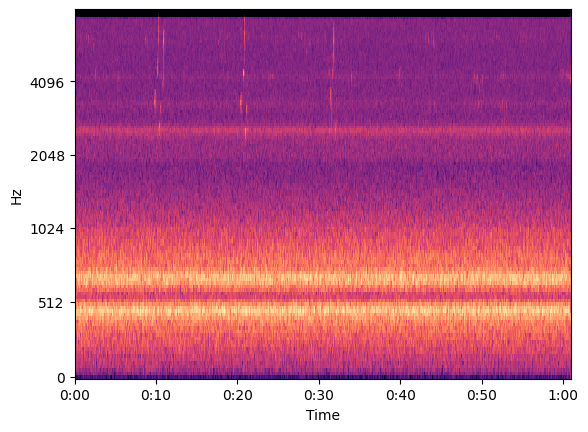

In [13]:
audio, sampling_rate = librosa.load(os.path.join(audio_dir, sp_file), sr=None)

window_ms = 40
window_samples = int((window_ms * sampling_rate) / 1000)

n_fft = int(2 ** np.ceil((np.log2(window_samples))))
hop_length = int(0.25 * window_samples)

S = librosa.feature.melspectrogram(y=audio,
                                   sr=sampling_rate,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   n_mels=128,
                                   fmax=8000)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, 
                               x_axis='time',
                               y_axis='mel', 
                               sr=sampling_rate,
                               n_fft=n_fft,
                               hop_length=hop_length,
                               fmax=8000, 
                               ax=ax)

# Perch Processing

Perch divides the audio into segments 5 seconds long and computes the embeddings. We can examine the logits (inputs of the softmax layer) and find the maximum logit. We see if any of the segment is correctly classified

In [14]:
audio, sampling_rate = librosa.load(os.path.join(audio_dir, sp_file), sr=32000)
_, wav_data = bhf.ensure_sample_rate(audio, sampling_rate)
test_frames = bhf.frame_audio(wav_data, hop_size_s=5)

all_logits, _ = model.infer_tf(test_frames[:1])
for window in test_frames[1:-1]:
    logits, _ = model.infer_tf(window[np.newaxis, :])
    all_logits = np.concatenate([all_logits, logits], axis=0)

2025-02-23 22:19:10.944005: I external/local_xla/xla/service/service.cc:168] XLA service 0x27d16060 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-02-23 22:19:10.944067: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-02-23 22:19:11.413539: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740338353.817432   98426 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-02-23 22:19:13.834900: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


In [15]:
correct_segments = []
for i in range(all_logits.shape[0]):
    if sp_index == ebird_labels[np.argmax(all_logits[i,:])]:
        correct_segments.append(i)

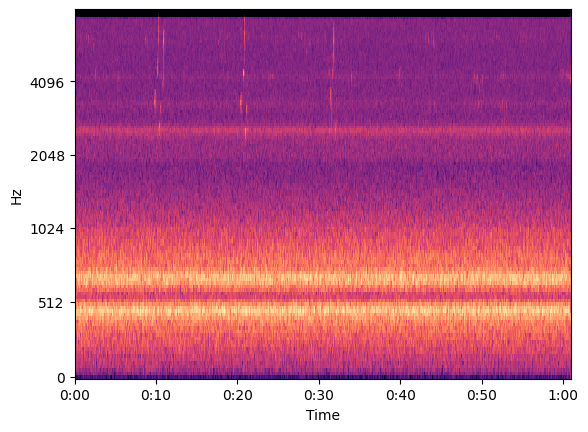

In [16]:
audio, sampling_rate = librosa.load(os.path.join(audio_dir, sp_file), sr=None)

window_ms = 40
window_samples = int((window_ms * sampling_rate) / 1000)

n_fft = int(2 ** np.ceil((np.log2(window_samples))))
hop_length = int(0.25 * window_samples)

S = librosa.feature.melspectrogram(y=audio,
                                   sr=sampling_rate,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   n_mels=128,
                                   fmax=8000)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, 
                               x_axis='time',
                               y_axis='mel', 
                               sr=sampling_rate,
                               n_fft=n_fft,
                               hop_length=hop_length,
                               fmax=8000, 
                               ax=ax)

for seg in correct_segments:
    plt.vlines(seg * 5, 0, 8000, linestyles='dashed', colors='k')
    plt.vlines((seg + 1)* 5, 0, 8000, linestyles='dashed', colors='k')

## Warbler classifier

We will derive embeddings from all the recordings with a single species and use the mean embedding as a feature for a logistic regression classifier.

In [17]:
embeddings_dir = '../embeddings/'
embedding_files = os.listdir(embeddings_dir)

In [18]:
labels = []
mean_embeddings = np.array([])
for embedding_file in embedding_files:
    labels.append(single_species_filenames[embedding_file.replace('npz', 'mp3')])
    npzfile = np.load(os.path.join(embeddings_dir, embedding_file))
    file_embeddings = npzfile['embeddings']

    if mean_embeddings.size:
        mean_embeddings = np.vstack((mean_embeddings, np.mean(file_embeddings, 0)))
    else:
        mean_embeddings = np.mean(file_embeddings, 0)

Turn into binary labels

In [19]:
new_labels = np.array([l in sp_select.options for l in labels]).astype(int)
    

In [20]:
X_train, X_test, y_train, y_test = train_test_split(mean_embeddings, new_labels, test_size=0.2, random_state=12)

In [21]:
classifier = LogisticRegression(max_iter=500)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [22]:
roc_auc = roc_auc_score(y_test, np.argmax(y_score, 1))

In [23]:
roc_auc

0.8513986013986014

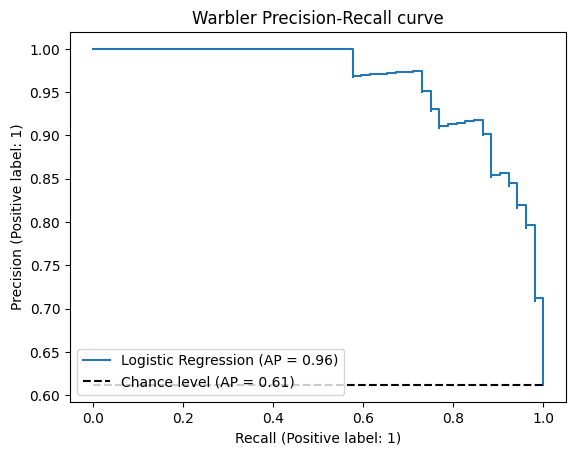

In [24]:
display = PrecisionRecallDisplay.from_estimator(
    classifier, X_test, y_test, name="Logistic Regression", plot_chance_level=True)
_ = display.ax_.set_title("Warbler Precision-Recall curve")


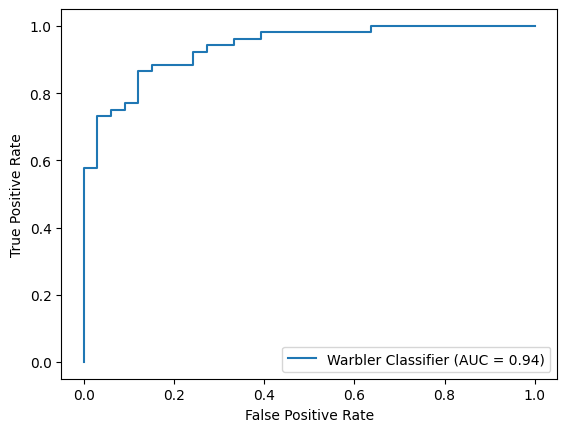

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,

                                  estimator_name='Warbler Classifier')

display.plot();